In [2]:

import os, warnings

from tensorflow_hub.keras_layer import keras

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


# reproducibility
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


set_seed()

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='gray')
warnings.filterwarnings('ignore')

# load training and load data
ds_train_ = image_dataset_from_directory(
    './data/car_or_truck/train',
    labels='inferred',
    shuffle=True,
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
)

ds_valid_ = image_dataset_from_directory(
    './data/car_or_truck/valid',
    labels='inferred',
    shuffle=True,
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
)


# Datapipeline
def convert_to_float_image(image, label):
    image = tf.cast(image, tf.float32)
    return image, label


AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float_image)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid_
    .map(convert_to_float_image)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    # First convolution block
    layers.Conv2D(32, kernel_size=5, activation='relu', padding='same', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(),

    # Second convolution block
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    # Third convolution block
    layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    # Classifier head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │       196,614 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,405 (1.11 MB)

 Trainable params: 291,405 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
model.compile(
    optimizer=keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=10,
    verbose=0,
)

2025-08-17 14:14:34.957285: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2025-08-17 14:14:35.666722: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2025-08-17 14:14:35.950471: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2025-08-17 14:14:36.527140: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2025-08-17 14:14:36.818443: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


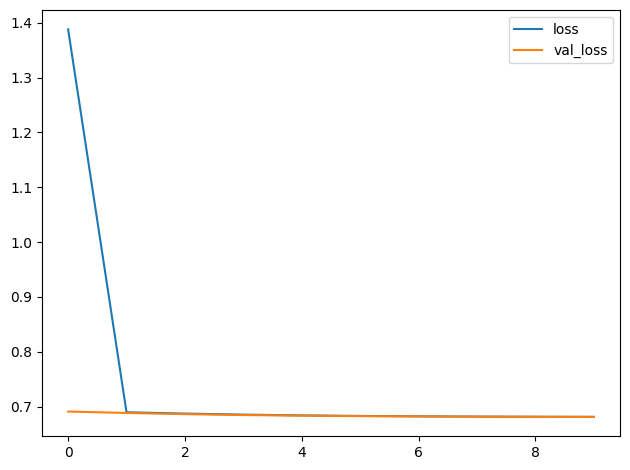

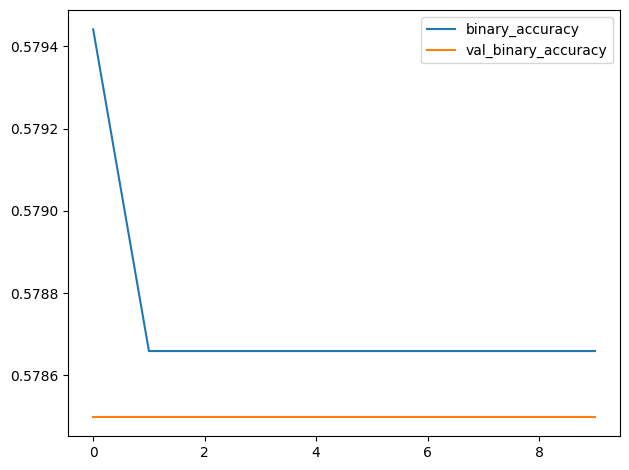

In [5]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();